## Setup a camera configuration for processing a single video
To process a video, a camera configuration is needed. The camera configuration makes the processing aware how to project the movie's frames to an orthorectified plane with real-world distances, and a user defined area of interest and processing resolution. It also tells the processing what the water level during the survey video is, so that the depth can be estimated, once bathymetry cross-sections are added. The process for a fixed video setup that takes videos with changing water level conditions is slightly more advanced. Therefore we here start with the assumption that you walk to a stream with a smart phone and a GPS (RTK) device or a spirit level instrument, record control points and record a short video for just one single observation.

In this notebook, we will extract one frame from the survey video to grab the control points. For this example, field observations were collected at the Ngwerere River, in Lusaka. We will first setup an empty camera configuration, and then gradually fill this with the required information. Along the way we plot what we have in a geospatial plot. The information we add is:
* Ground-control points (row and columns locations in the frame as well as real world coordinates)
* Row and column coordinates that define the area of interest.
* The water level during the video and survey (set at zero, because this survey was only done for one single video, this is only relevant if multiple videos with different water levels are processed)
* The position of the camera lens. This is relevant in case multiple videos with different water levels are processed. We here add this, but it is not actually used. 


In [1]:
import xarray as xr
import pyorc
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Open movie and plot the first frame
We use the pyorc Video class to open a video file and extract frame number #0 (remember, python starts counting at zero instead of one). Several markers have been placed, some as square shaped checkerboard patterns, others spraypainted with black paint on a rock. All markers are more or less at the water level. If you want to interactively view coordinates you can add `%matplotlib notebook` to the top of the cell. You can then hover over the image with your mouse and see the coordinates in the bottom-right. velocimetry is normally done on one image channel (greyscale), but we first explicitly use `method="rgb"` to extract one frame in rgb colorspace for finding the points.

Scanning video: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


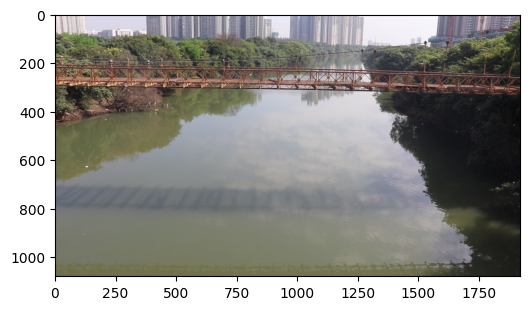

In [2]:
#%matplotlib notebook
video_file = r"D:\STIV-based-Velocity-Estimation\Dataset_HW\bridge_main_1.MP4"
video = pyorc.Video(video_file, start_frame=0, end_frame=1)  # we only need one frame
frame = video.get_frame(0, method="rgb")

# plot frame on a notebook-style window
f = plt.figure(figsize=(6, 6))
plt.imshow(frame)
plt.savefig("BR_final.png")



You can identify different marker x (column) and y (row) positions in the camera's objective. Below, we have put several of these into a "src" part of the required gcp dictionary. Then we plot the frame and coordinates together.

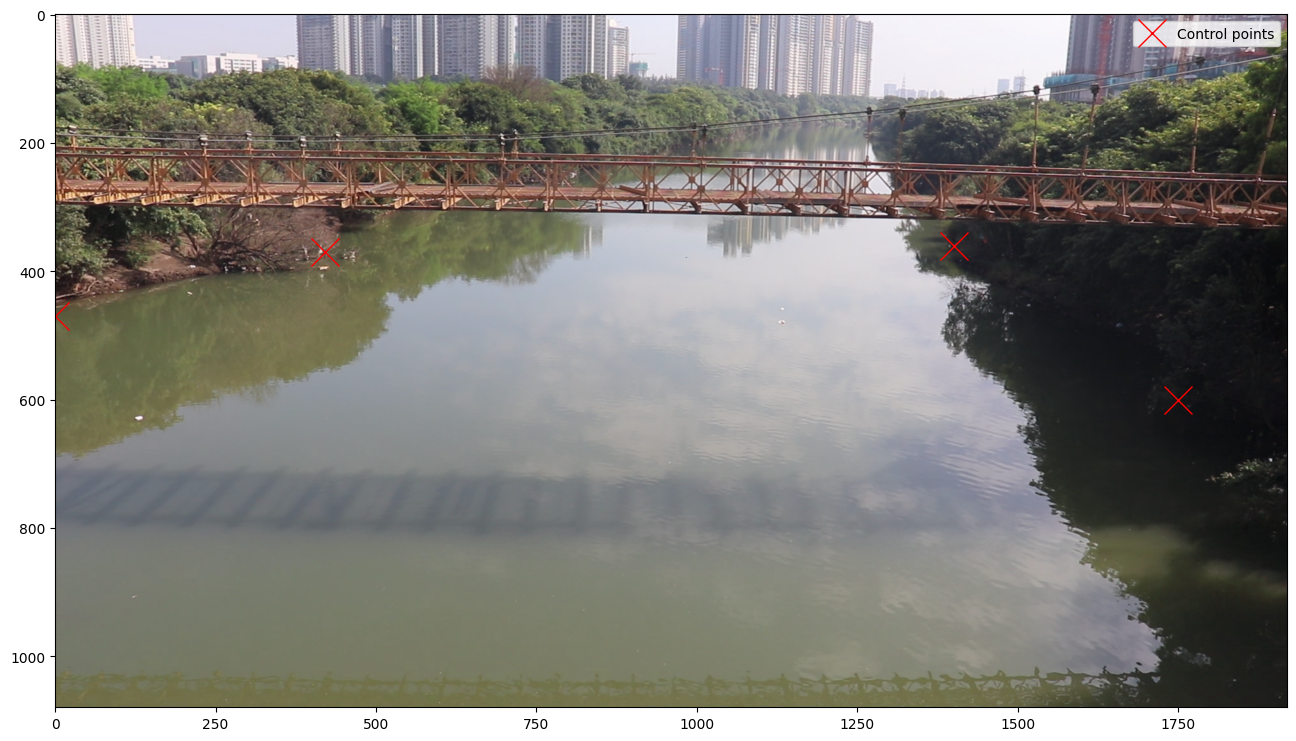

In [3]:
%matplotlib inline
gcps = dict(
    src=[
    [1750, 600],   # bottom right
    [1400 , 360],   #  top right 
    [420, 370],    # top left 
    [0 , 470]     # bottom left 
]
)

f = plt.figure(figsize=(16, 9))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.legend()

# current cords - 18.56899 , 73.733471


Now we add the rest of the information: 

* the real world coordinates of the GCPs. These were measured using an RTK GPS unit in the Universe Transverse Mercator (UTM) 35S coordinate reference system (EPSG code 32735). We add these to the GCPs using another key called "dst".
* the water level during the survey as measured in the EPSG 32735 projection (`z_0`), which is measured by the RTK GPS unit. This is used to later compute depths from a bathymetry section, measured in the same EPSG 32735 ellipsoid vertical reference.
* the coordinate reference system (`crs`). The camera configuration then understands that everything we do is in UTM 35S. Really nice, because it makes our results geographically aware and geographical plots can be made. We add the crs to the camera configuration while setting it up.

Note that in case you have a fixed camera that regularly takes movies at different water levels, you also would need to set the following:

* the locally measured water level `h_ref` during your survey. Typically this comes from a staff gauge, that a local person reads out or a pressure gauge. For each video, a new water level must then be provided, which is used to relocate the ground control points to the right location for the new water level, and to estimate the depth over cross-sections, applied later in the process. Since we here process a single video, we don't have to worry about this. 


In [5]:
# first add our UTM 35S coordinates. This MUST be in precisely the same order as the src coordinates.

"""
current sector - 43Q
Z:
43Q
E:
366342.337
N:
2053602.338

"""
gcps["dst"] = [
    [366400.720, 2053619.745],  # lowest right coordinate
    [366418.640, 2053631.682],  # highest right coordinate
    [366362.501, 2053663.064] ,# highest left coordinate
    [366353.367, 2053654.939]  # lowest  left coordinate
    
]

# # if we would use this video as survey in video, the lines below are also needed, 
# # and proper values need to be filled in. They are now commented out.
# gcps["h_ref"] = <your locally measured water level during survey in>
gcps["z_0"] = 1182.2

# set the height and width
height, width = frame.shape[0:2]

# now we use everything to make a camera configuration
cam_config = pyorc.CameraConfig(height=height, width=width, gcps=gcps, crs=32643  )


Below we make a quick plot. Cartopy is used to make the plot geographically aware. We use GoogleTiles, using the satellite style, to get some awareness of the surroundings.

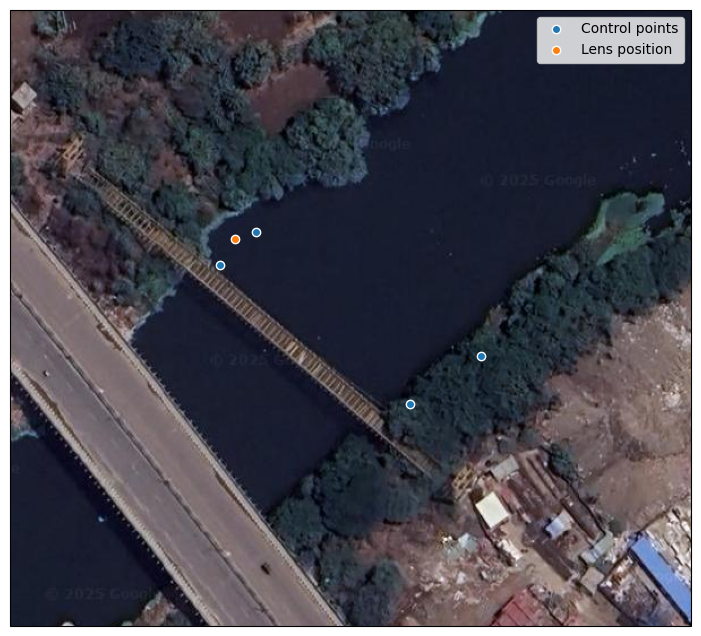

In [6]:
ax = cam_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"})


Finally we add information to define our area of interest, and how the camera objective must be reprojected and the resolution of the velocimetry. 
* For the area of interest, 4 coordinates must be selected in the camera perspective. A geographically rectangular box will be shaped around those to make a suitable area of interest. We can simply use pixel (column row) xy coordinates for this, so we can select them using the original frame. Below, 4 points are selected and shown in the camera objective.
* a target resolution (in meters) must be selected. The resolution is used to reproject the camera objective to a planar projection with real-world coordinates.
* a window size (in number of pixels) is needed. Velocimetry will be performed in windows of this size. Since the stream is quite small, we use 1 centimeter (0.01 m) and a 25 pixel (so 25 centimeter) window size, used to find patterns on the water to trace.


In [ ]:
corners = [
    [292, 817],
    [500, 400],
    [1200, 400],
    [1600, 834]
]
cam_config.set_bbox_from_corners(corners)
cam_config.resolution = 0.01
cam_config.window_size = 25

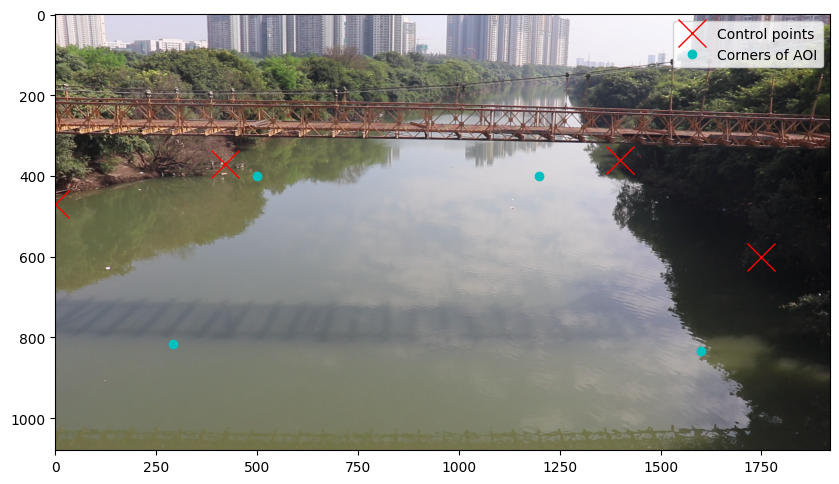

In [ ]:

f = plt.figure(figsize=(10, 6))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.plot(*zip(*corners), "co", label="Corners of AOI")
plt.legend()


Now that all information is entered, we show the final camera configuration as a plot, both in geographical projection and in camera perspective. The rectangular box can be clearly seen now.

C:\Users\dhaba\AppData\Local\Temp\ipykernel_22380\420364497.py:3: DeprecationWarning: The camera=True option is deprecated, use mode='camera' instead. This option will be removed in a future release.
  ax1 = cam_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"} , camera=True)
C:\Users\dhaba\AppData\Local\Temp\ipykernel_22380\420364497.py:8: DeprecationWarning: The camera=True option is deprecated, use mode='camera' instead. This option will be removed in a future release.
  cam_config.plot(ax=ax2, camera=True)


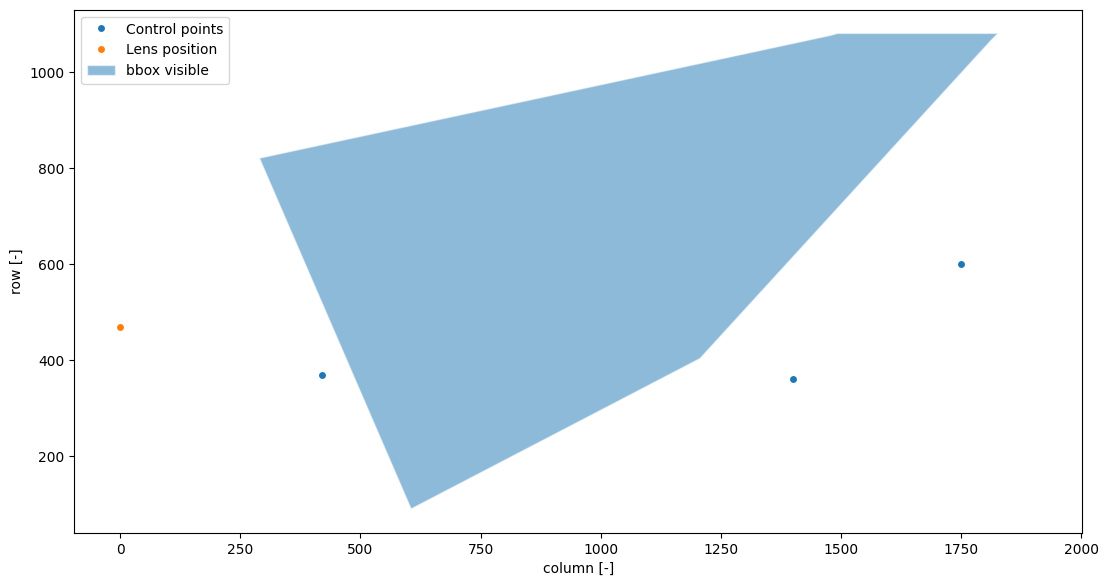

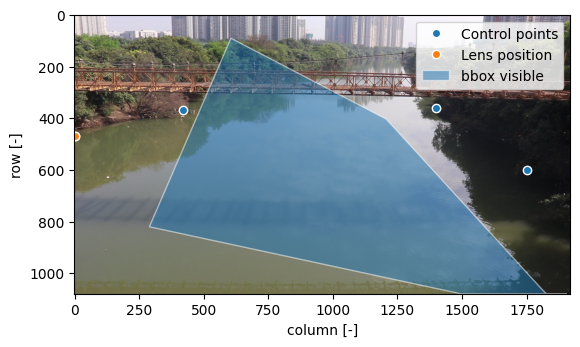

In [ ]:
%matplotlib inline

ax1 = cam_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"} , camera=True)

f = plt.figure()
ax2 = plt.axes()
ax2.imshow(frame)
cam_config.plot(ax=ax2, camera=True)

plt.savefig("BR_cam_config_plot.jpg", bbox_inches="tight", dpi=72)

To better grasp the perspective and the situation, a 3D plot may be very useful. The camera configuration has a powerful 3D plotting method.

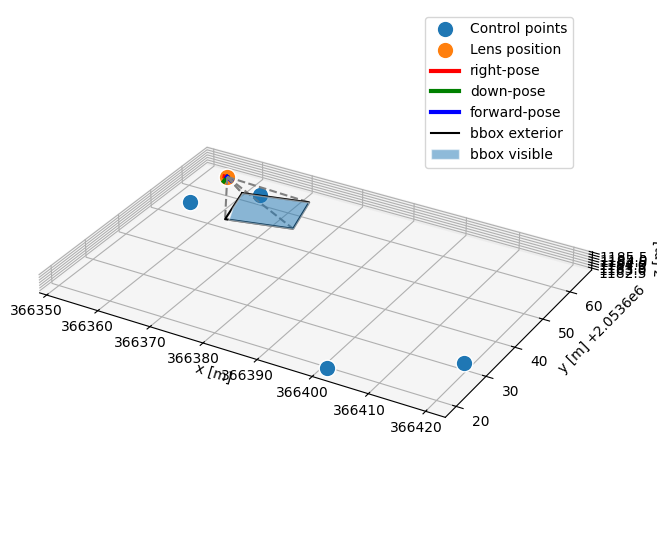

In [ ]:
# for interactive plotting, please install ipython matplotlib e.g. through `pip install ipympl`. You may need additional requirements, see https://matplotlib.org/ipympl/installing.html
# then uncomment the line below.
%matplotlib inline
plt.close("all")
f = plt.figure(figsize=(12, 7))
ax = f.add_subplot(projection="3d")
cam_config.plot(mode="3d", ax=ax)
ax.set_aspect("equal")

Our camera configuration is ready. Below we still show a string representation and then we store the configuration to a file for use in our next notebook using the `.to_file` method.

In [ ]:
print(cam_config)
cam_config.to_file("ngwerere.json")

{
    "height": 1080,
    "width": 1920,
    "crs": "PROJCRS[\"WGS 84 / UTM zone 43N\",BASEGEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geodetic System 1984 ensemble\",MEMBER[\"World Geodetic System 1984 (Transit)\"],MEMBER[\"World Geodetic System 1984 (G730)\"],MEMBER[\"World Geodetic System 1984 (G873)\"],MEMBER[\"World Geodetic System 1984 (G1150)\"],MEMBER[\"World Geodetic System 1984 (G1674)\"],MEMBER[\"World Geodetic System 1984 (G1762)\"],MEMBER[\"World Geodetic System 1984 (G2139)\"],MEMBER[\"World Geodetic System 1984 (G2296)\"],ELLIPSOID[\"WGS 84\",6378137,298.257223563,LENGTHUNIT[\"metre\",1]],ENSEMBLEACCURACY[2.0]],PRIMEM[\"Greenwich\",0,ANGLEUNIT[\"degree\",0.0174532925199433]],ID[\"EPSG\",4326]],CONVERSION[\"UTM zone 43N\",METHOD[\"Transverse Mercator\",ID[\"EPSG\",9807]],PARAMETER[\"Latitude of natural origin\",0,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8801]],PARAMETER[\"Longitude of natural origin\",75,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8802]],PARA